In [1]:
import os
import glob
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import ToTensor

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix

import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, CrossEntropyLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
# torch.set_default_device('cuda')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
IMAGE_SIZE = 16

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.to(device)),
        
    ]),
    "test": transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.to(device)) ]),
}                                 

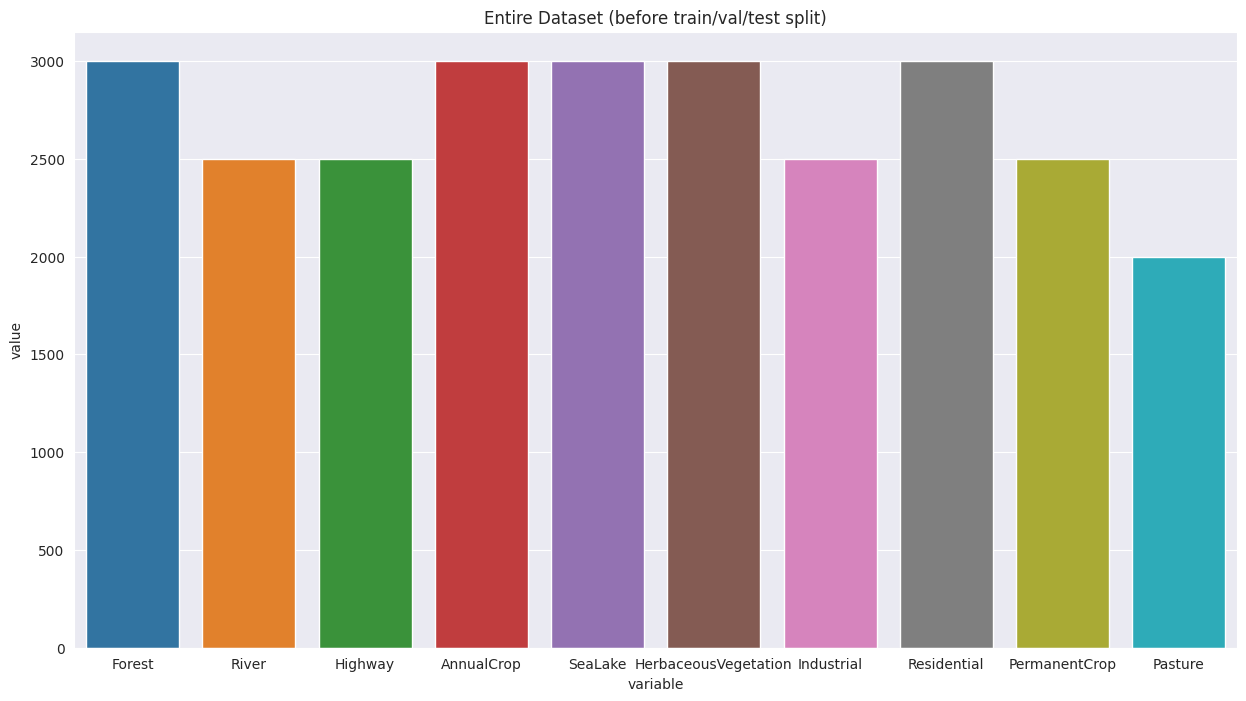

In [6]:
class MultiClassImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
        self.image_paths = []
        self.labels = []

        class_length = {}
        for label, class_folder in enumerate(self.class_folders):
            img_paths = glob.glob(os.path.join(root_dir, class_folder, '*.jpg'))
            class_length[class_folder] = int(len(img_paths))
            self.image_paths.extend(img_paths)
            self.labels.extend([label] * len(img_paths))
        
        plt.figure(figsize=(15,8)) 
        self.plot_from_dict(class_length, plot_title="Entire Dataset (before train/val/test split)")
    
            
    def plot_from_dict(self, dict_obj, plot_title, **kwargs):
        return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)


    def __len__(self):
        return len(self.image_paths)
    
    

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label


root_dir = "/home/aws_install/projects/QCML/QNN4EO/Dataset/EuroSAT_RGB/"
dataSet = MultiClassImageDataset(root_dir, image_transforms["train"])

In [7]:
BATCH_SIZE = 256
train_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=dataSet, shuffle=True, batch_size=1)

In [8]:
d = next(iter(train_loader))
print("Train Image" , d[0].shape)
print("Train Label" , d[1])

Train Image torch.Size([256, 3, 16, 16])
Train Label tensor([8, 9, 5, 4, 6, 9, 0, 9, 9, 0, 4, 0, 8, 3, 9, 7, 2, 0, 6, 3, 9, 5, 6, 7,
        9, 5, 4, 0, 2, 3, 0, 8, 6, 2, 3, 7, 2, 7, 3, 8, 5, 4, 3, 8, 3, 0, 2, 3,
        6, 1, 7, 3, 5, 6, 1, 5, 4, 7, 0, 1, 3, 5, 7, 4, 2, 2, 1, 5, 1, 2, 1, 7,
        5, 7, 6, 4, 5, 3, 6, 2, 2, 1, 5, 9, 8, 3, 5, 8, 2, 4, 8, 0, 2, 1, 1, 7,
        1, 8, 5, 8, 7, 6, 2, 7, 1, 7, 8, 0, 7, 3, 0, 6, 3, 2, 2, 3, 4, 1, 4, 0,
        2, 4, 2, 4, 5, 2, 0, 1, 0, 0, 6, 7, 6, 2, 5, 1, 7, 2, 9, 7, 1, 5, 8, 4,
        6, 4, 7, 6, 9, 9, 3, 5, 1, 3, 5, 7, 1, 5, 5, 1, 8, 2, 5, 3, 3, 0, 8, 5,
        7, 5, 8, 5, 9, 4, 1, 3, 2, 3, 8, 7, 3, 7, 0, 3, 5, 3, 4, 5, 8, 7, 3, 1,
        8, 3, 2, 9, 8, 5, 0, 0, 6, 5, 8, 6, 7, 6, 9, 0, 0, 8, 3, 8, 0, 2, 7, 2,
        1, 4, 8, 5, 0, 4, 5, 9, 7, 6, 7, 7, 5, 0, 0, 0, 7, 0, 7, 1, 6, 2, 8, 7,
        6, 2, 8, 5, 0, 3, 0, 4, 7, 1, 5, 5, 6, 0, 6, 2])


In [9]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(4)
    ansatz = RealAmplitudes(4, reps=1)
    qc = QuantumCircuit(4)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    print(qc.draw())

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


QC_NN = create_qnn()

     ┌────────────────────────────────────┐»
q_0: ┤0                                   ├»
     │                                    │»
q_1: ┤1                                   ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │»
q_2: ┤2                                   ├»
     │                                    │»
q_3: ┤3                                   ├»
     └────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────┐
«q_0: ┤0                                                         ├
«     │                                                          │
«q_1: ┤1                                                         ├
«     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
«q_2: ┤2                                                         ├
«     │                                                          │
«q_3: ┤3                                                         ├
«     └────────────────────────────────────────────────────

In [12]:
# Define torch NN module
class Base_Model(Module):
    def __init__(self, QC_NN):
        super().__init__()
        self.conv1 = Conv2d(3, 16, kernel_size=5)
        self.conv2 = Conv2d(16, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(16, 64) # 2704 for 64 , 16 for 16
        self.fc2 = Linear(64, 4)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(QC_NN)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 10)  # 1-dimensional output from QNN
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return self.activation(x)


multiClassBaseModel = Base_Model(QC_NN).to(device)

In [14]:
optimizer = optim.Adam(multiClassBaseModel.parameters(), lr=0.001)
loss_func = CrossEntropyLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
multiClassBaseModel.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target= target.to(device)
        data= data.to(device)
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = multiClassBaseModel(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
        print(loss)
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch

# Create a tensor on the CPU
x = torch.randn(3, 3)

# Move the tensor to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)

Using device: cuda


In [13]:
x

tensor([[-0.7918, -1.4692, -0.0881],
        [-1.8712, -0.4111, -0.5474],
        [-0.8929, -0.8563, -0.6927]], device='cuda:0')